In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.519373  0.555951  0.657804  0.369253  0.556282 -0.250889 -0.206489   
  1  -0.368100  0.706790  0.820641 -0.148476 -0.348453 -0.122763 -0.681956   
  2   0.741568  0.922350 -0.366894 -0.811581 -0.745845  0.928430 -0.389243   
  3   0.814079 -0.023983 -0.223280 -0.236624 -0.145159  0.160298 -0.830208   
  4   1.464041  0.290371  0.419583  0.214439 -0.590978 -0.485317  0.129255   
  5   0.894674 -0.085362  0.536974 -0.002439  0.340458 -0.113697  0.180685   
  6  -0.578762  0.276467 -0.469443 -1.165240 -1.361043  0.374119 -1.355385   
  7   0.000748 -0.560945 -0.324114  0.482189 -0.064467 -0.092203 -0.083583   
  8   0.445309  0.068084  0.463846  0.558004 -0.238604 -1.194589 -0.829721   
  9   0.537866  0.024901  0.459805 -0.433672 -0.674854 -0.041309 -0.392176   
  10  0.163435 -0.355376  0.300643  1.159466 -0.434875  0.672733  0.326222   
  11 -0.142417 -0.461715 -0.482105 -0.013812 -0.291472  0.710363 -0.303131   
  12  0.408978  0.854679  0.531809  0.658085  0.386702  0.740615  0.417115   
  13 -0.441796 -0.949026  0.567410  0.535002  0.401314 -0.375516 -0.606282   
  14 -0.284927  0.011457  0.002525  0.810292  0.285885  0.399982 -0.390462   
  15  0.905850  0.175552  0.087588  0.250145 -0.129029  0.510282 -0.689290   
  16 -0.341706 -0.186328  0.236640 -0.589200  0.540499  0.680334 -0.185385   
  17 -0.784901  0.462297  1.064998  0.763758  0.322396 -0.286637 -0.650191   
  18  0.822132  0.384178  0.602328  1.268795  0.305547 -0.249150  0.216799   
  19 -0.047006  0.349538 -0.297769  0.341003 -0.252915 -0.775876 -0.283104   
  20 -0.204016  0.134878  0.636215  1.063633  1.297513  0.653361 -0.043722   
  21 -0.029592  0.326629  0.668956 -0.556460  0.777528 -0.308448  0.375161   
  22 -0.654908 -0.693194  0.249096  0.324626 -0.625627  0.498968  0.593489   
  23 -1.067049 -0.357803  0.557810 -0.065278 -0.311411  0.031112 -0.392024   
  24  0.209620  0.066265 -0.601137  1.184777 -0.280194 -0.453784 -1.361561   
1 0  -0.570768 -0.379762 -0.058461 -0.119177  0.635684 -0.581009  0.171342   
  1  -0.677042 -0.359570  0.082241  0.051192  0.550880 -0.331242 -0.022123   
  2   0.530666  0.355054 -0.373220 -0.576362 -0.443752  0.175318  1.006123   
  3   0.416660 -0.446903  0.184330 -0.506445 -0.331589 -0.623516 -1.111440   
  4  -0.123790  0.029638  0.369267 -0.430058 -0.404907 -0.386561 -0.446851   

            X8        X9       X10  ...       X94       X95       X96  \
0 0   0.321713 -0.416437  0.252028  ...  0.096458  0.460552 -0.836501   
  1   0.119989 -0.756801 -0.481608  ...  0.577685 -0.435685 -0.125062   
  2  -0.536869 -0.114736  0.232342  ...  1.098234  1.233114  0.584412   
  3   0.936004  0.243113  0.217673  ...  1.067557  0.398097  0.615201   
  4   0.160629  0.370652 -0.464441  ... -0.727162  0.632667  0.354044   
  5   0.866019 -0.149775 -0.563419  ...  1.240945  0.272118 -0.110084   
  6  -0.183798  0.015532  0.974431  ...  0.805241 -0.921642 -0.817050   
  7  -0.408538  0.410633  0.109717  ...  0.352028  0.435357  0.636906   
  8   0.356155 -0.170670  0.073215  ...  0.798769  0.365878 -0.766938   
  9   0.404730  0.786123  0.401919  ... -0.667585 -0.156484  0.244460   
  10  0.662049  0.027193  0.130053  ...  1.028403 -0.281475  0.088629   
  11  0.007488  0.016014  0.163797  ...  1.525311  0.013359 -0.098962   
  12  0.318735  0.100618  0.829156  ...  0.274152  0.524539  0.145451   
  13 -0.831925 -0.369426 -1.322450  ...  0.404607  0.347505  0.436513   
  14  0.192451 -0.422429 -0.650864  ...  0.272921 -0.140903 -0.523091   
  15 -0.140869 -0.040177 -0.124258  ...  0.240683  0.596671 -0.687304   
  16  0.260884 -1.194904  0.030336  ... -0.447067  0.122695  0.848481   
  17  0.273811 -0.205605 -0.043142  ... -0.295809  0.196170 -0.508398   
  18 -0.151757 -0.016609  0.294020  ... -0.046901  0.391475 -0.581500   
  19  0.192703 -0.045859 -1.157160  ...  0.454060 -0.026618 -0.534880   
  20  0.096662 -0.111086  0.535541  ... -0.191727  0.257440 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %    97.5 %
D  1.068749  0.037606  28.419646  1.156410e-177  0.995042  1.142455


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



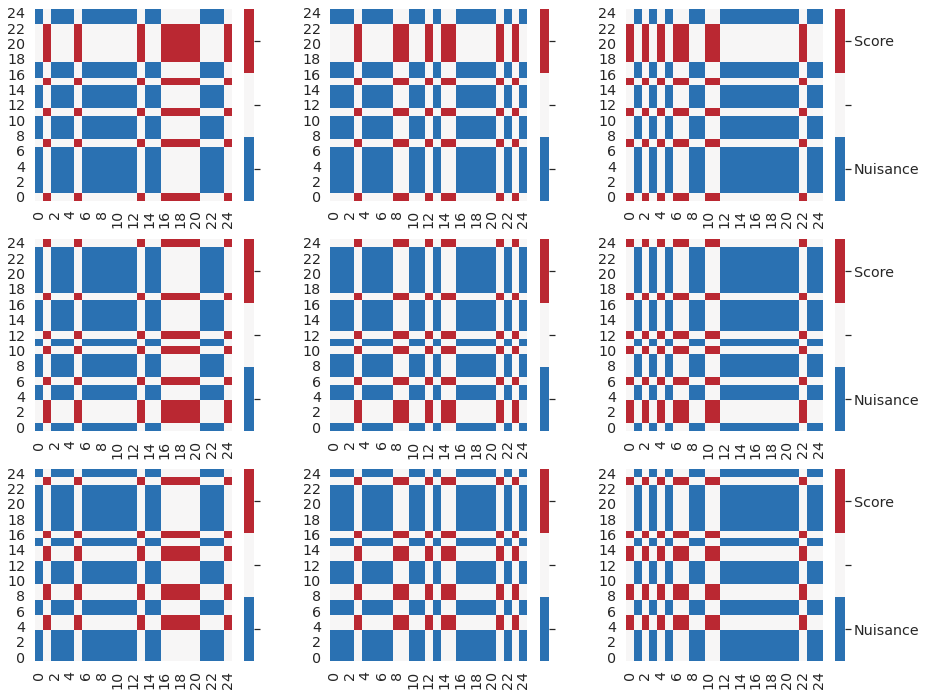

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



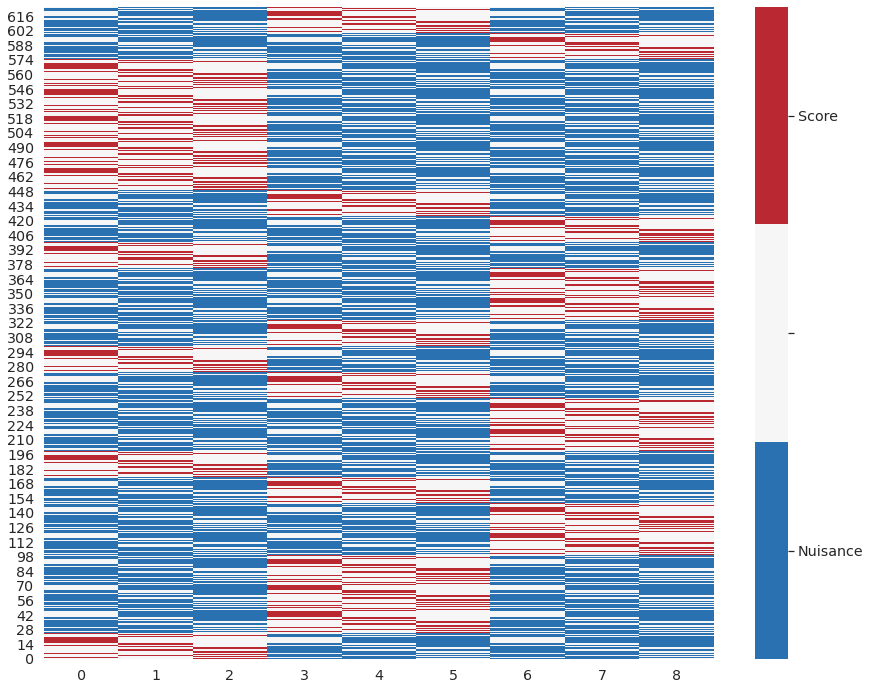

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])